# Qwen3-VL Reranker Model Examples

This notebook demonstrates how to use the Qwen3-VL reranker model to rerank retrieval results generated by `embedding.ipynb`.

**Text Tasks**
- Text Retrieval Reranking

**Image Tasks**
- Image Retrieval Reranking

**Note**: Please run `embedding.ipynb` first to generate `./retrieval_results/text_retrieval_results.pkl` and `./retrieval_results/image_retrieval_results.pkl`.

---
# Part 0: Setup

## 0.1 Import Packages

In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

## 0.2 Load Reranker Model

In [2]:
sys.path.append(str(Path("..").resolve()))
from src.models.qwen3_vl_reranker import Qwen3VLReranker

MODEL_PATH = r"./models/Qwen3-VL-Reranker-2B" # "your model path"
INPUT_DIR = "./retrieval_results"
OUTPUT_DIR = "./rerank_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

reranker = Qwen3VLReranker(
    model_name_or_path=MODEL_PATH,
    max_length=8192,
    max_frames=16,
    fps=1
)

print("Reranker model loaded successfully!")

Reranker model loaded successfully!


## 0.3 Helper Functions

In [3]:
def safe_load_pkl(path: str):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}. Please run embedding.ipynb first.")
    with open(path, "rb") as f:
        return pickle.load(f)

def rerank_candidates(instruction: str, query: dict, documents: list):
    """Call reranker and return scores as np.array."""
    payload = {
        "instruction": instruction,
        "query": query,
        "documents": documents,
    }
    scores = reranker.process(payload)
    return np.asarray(scores, dtype=np.float32)

def display_rank_comparison(emb_res, rerank_res):
    gt_idx = emb_res.get('gt_idx', None)
    if gt_idx is None:
        return {"emb_rank": "N/A", "rerank_rank": "N/A", "improvement": ""}

    emb_rank = emb_res['ranked_indices'].index(gt_idx) + 1 if gt_idx in emb_res['ranked_indices'] else -1
    rerank_rank = rerank_res['reranked_indices'].index(gt_idx) + 1 if gt_idx in rerank_res['reranked_indices'] else -1

    improvement = ""
    if emb_rank > 0 and rerank_rank > 0:
        if rerank_rank < emb_rank:
            improvement = f"↑ Improved by {emb_rank - rerank_rank} positions"
        elif rerank_rank > emb_rank:
            improvement = f"↓ Dropped by {rerank_rank - emb_rank} positions"
        else:
            improvement = "→ No change"

    return {
        "emb_rank": emb_rank if emb_rank > 0 else "Not in Top-K",
        "rerank_rank": rerank_rank if rerank_rank > 0 else "Not in Top-K",
        "improvement": improvement
    }

def compute_metrics(emb_results, rerank_results):
    """Compute MRR and Recall@K metrics."""
    metrics = {
        "emb": {"mrr": 0.0, "r@1": 0.0, "r@5": 0.0},
        "rerank": {"mrr": 0.0, "r@1": 0.0, "r@5": 0.0}
    }
    n = len(emb_results)
    if n == 0:
        return metrics

    for emb_res, rerank_res in zip(emb_results, rerank_results):
        gt_idx = emb_res['gt_idx']

        # Embedding metrics
        if gt_idx in emb_res['ranked_indices']:
            rank = emb_res['ranked_indices'].index(gt_idx) + 1
            metrics['emb']['mrr'] += 1.0 / rank
            if rank <= 1: metrics['emb']['r@1'] += 1.0
            if rank <= 5: metrics['emb']['r@5'] += 1.0

        # Rerank metrics
        if gt_idx in rerank_res['reranked_indices']:
            rank = rerank_res['reranked_indices'].index(gt_idx) + 1
            metrics['rerank']['mrr'] += 1.0 / rank
            if rank <= 1: metrics['rerank']['r@1'] += 1.0
            if rank <= 5: metrics['rerank']['r@5'] += 1.0

    for key in metrics:
        for m in metrics[key]:
            metrics[key][m] /= n

    return metrics

TOP_K = 10

---
# Part 1: Text Tasks

## 1.1 Text Retrieval Reranking

Load `text_retrieval_results.pkl` from `embedding.ipynb`, rerank the top-k candidates for each query.

In [4]:
# Load embedding results
text_path = os.path.join(INPUT_DIR, "text_retrieval_results.pkl")
text_data = safe_load_pkl(text_path)

text_corpus = text_data['corpus']
text_emb_results = text_data['results']

print(f"Loaded {len(text_emb_results)} text queries for reranking")
print(f"Corpus size: {len(text_corpus)}")

Loaded 2 text queries for reranking
Corpus size: 821


In [5]:
# Rerank
text_rerank_results = []

for res in text_emb_results:
    candidate_indices = res['ranked_indices'][:TOP_K]

    rerank_scores = rerank_candidates(
        instruction="Given a query, retrieve passages that are relevant to the query.",
        query={"text": res['query']},
        documents=[{"text": text_corpus[idx]} for idx in candidate_indices],
    )

    rerank_order = np.argsort(rerank_scores)[::-1]
    reranked_indices = [candidate_indices[int(j)] for j in rerank_order]
    reranked_scores = [float(rerank_scores[int(j)]) for j in rerank_order]

    text_rerank_results.append({
        "reranked_indices": reranked_indices,
        "reranked_scores": reranked_scores
    })

print("Text reranking completed!")

Text reranking completed!


In [6]:
# Display results
print("\n" + "=" * 80)
print("TEXT RETRIEVAL RERANKING RESULTS")
print("=" * 80)

for i, (emb_res, rerank_res) in enumerate(zip(text_emb_results, text_rerank_results)):
    print(f"\nQuery {i+1}: {emb_res['query']}")
    print(f"Ground Truth: {emb_res['gt_passage'][:80]}...")
    print()

    gt_idx = emb_res['gt_idx']

    # Before reranking
    print("Before Reranking (Embedding Top-5):")
    for rank, (idx, score) in enumerate(zip(emb_res['ranked_indices'][:5], emb_res['ranked_scores'][:5]), 1):
        marker = "✓" if idx == gt_idx else " "
        print(f"  {rank}. [{marker}] (score: {score:.4f}) {text_corpus[idx][:60]}...")
    print()

    # After reranking
    print("After Reranking (Top-5):")
    for rank, (idx, score) in enumerate(zip(rerank_res['reranked_indices'][:5], rerank_res['reranked_scores'][:5]), 1):
        marker = "✓" if idx == gt_idx else " "
        print(f"  {rank}. [{marker}] (score: {score:.4f}) {text_corpus[idx][:60]}...")

    comp = display_rank_comparison(emb_res, rerank_res)
    print(f"\nGround Truth Rank: {comp['emb_rank']} → {comp['rerank_rank']} {comp['improvement']}")
    print("-" * 80)


TEXT RETRIEVAL RERANKING RESULTS

Query 1: walgreens store sales average
Ground Truth: The average Walgreens salary ranges from approximately $15,000 per year for Cust...

Before Reranking (Embedding Top-5):
  1. [ ] (score: 0.7988) th store in 1984, reaching $4 billion in sales in 1987, and ...
  2. [ ] (score: 0.7901) The number of Walgreen stores has risen from 5,000 in 2005 t...
  3. [✓] (score: 0.7709) The average Walgreens salary ranges from approximately $15,0...
  4. [ ] (score: 0.7281) In fiscal 2014, Walgreens opened a total of 184 new location...
  5. [ ] (score: 0.7001) Your Walgreens Store. Select a store from the search results...

After Reranking (Top-5):
  1. [ ] (score: 0.6761) The number of Walgreen stores has risen from 5,000 in 2005 t...
  2. [ ] (score: 0.6252) In fiscal 2014, Walgreens opened a total of 184 new location...
  3. [✓] (score: 0.5248) The average Walgreens salary ranges from approximately $15,0...
  4. [ ] (score: 0.5240) th store in 1984, reaching $

In [7]:
# Save for analysis
text_save_data = {
    "results": text_rerank_results,
    "meta": {
        "input_pkl": text_path,
        "top_k": TOP_K
    }
}
out_text = os.path.join(OUTPUT_DIR, "text_rerank_results.pkl")
with open(out_text, "wb") as f:
    pickle.dump(text_save_data, f)
print(f"Saved to {out_text}")

Saved to ./rerank_results/text_rerank_results.pkl


---
# Part 2: Image Tasks

## 2.1 Image Retrieval Reranking

Load `image_retrieval_results.pkl` from `embedding.ipynb`, rerank the top-k candidates for each query caption.

In [8]:
# Load embedding results
image_path = os.path.join(INPUT_DIR, "image_retrieval_results.pkl")
image_data = safe_load_pkl(image_path)

image_corpus_paths = image_data['corpus_paths']
image_captions = image_data['captions']
image_emb_results = image_data['results']

# Load images
image_corpus = [Image.open(p) for p in image_corpus_paths]

print(f"Loaded {len(image_emb_results)} image queries for reranking")
print(f"Corpus size: {len(image_corpus)}")

Loaded 2 image queries for reranking
Corpus size: 10


In [9]:
# Rerank
image_rerank_results = []

for res in image_emb_results:
    candidate_indices = res['ranked_indices'][:TOP_K]

    rerank_scores = rerank_candidates(
        instruction="Given a caption, determine if the image matches the description.",
        query={"text": res['caption']},
        documents=[{"image": image_corpus[idx]} for idx in candidate_indices],
    )

    rerank_order = np.argsort(rerank_scores)[::-1]
    reranked_indices = [candidate_indices[int(j)] for j in rerank_order]
    reranked_scores = [float(rerank_scores[int(j)]) for j in rerank_order]

    image_rerank_results.append({
        "reranked_indices": reranked_indices,
        "reranked_scores": reranked_scores
    })

print("Image reranking completed!")

Image reranking completed!



IMAGE RETRIEVAL RERANKING RESULTS

Query 1: A man with a red helmet on a small moped on a dirt road. 

Ground Truth Image:


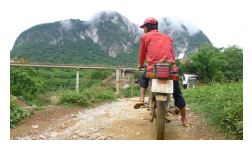

Before Reranking (Embedding Top-5):


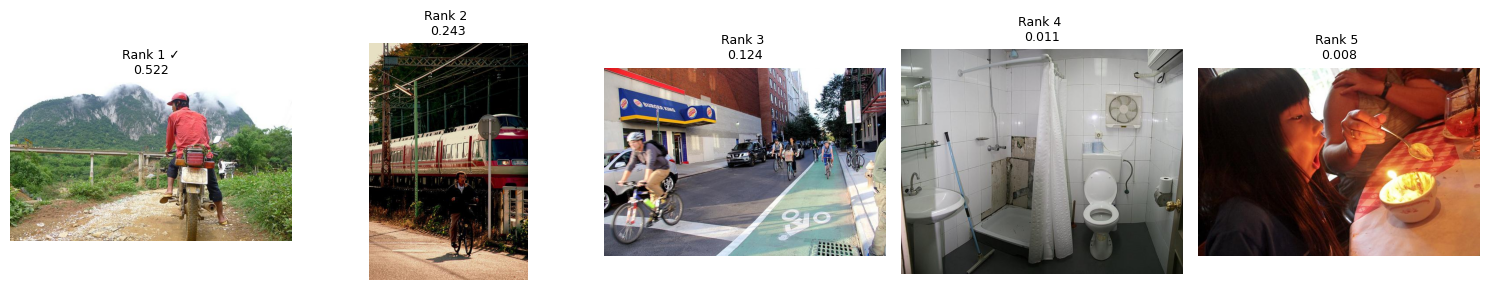

After Reranking (Top-5):


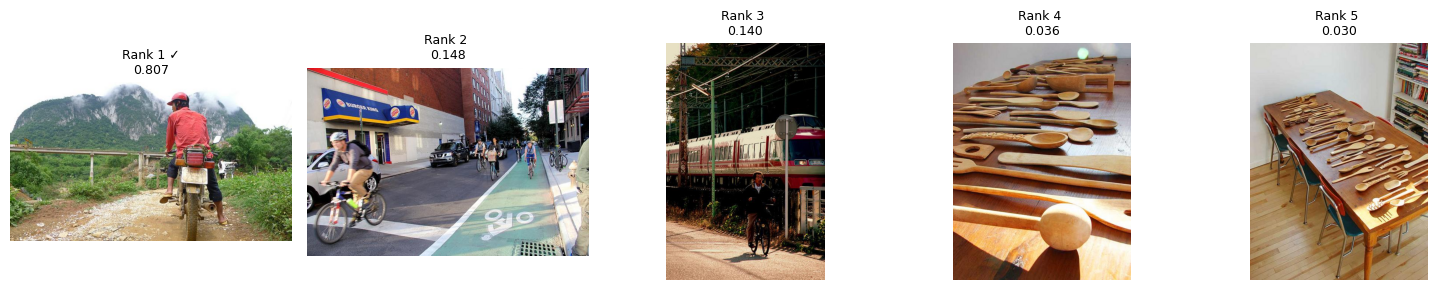

Ground Truth Rank: 1 → 1 → No change
--------------------------------------------------------------------------------

Query 2: The bathroom is clean and ready to be used. 

Ground Truth Image:


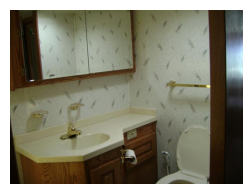

Before Reranking (Embedding Top-5):


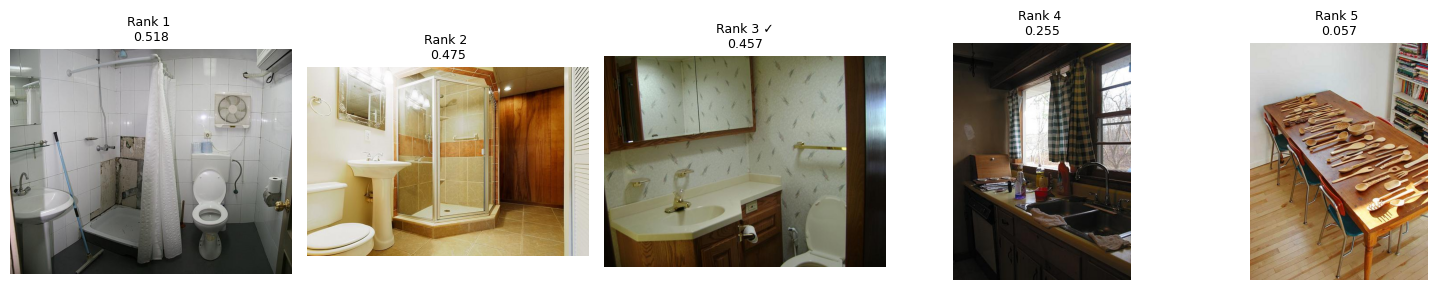

After Reranking (Top-5):


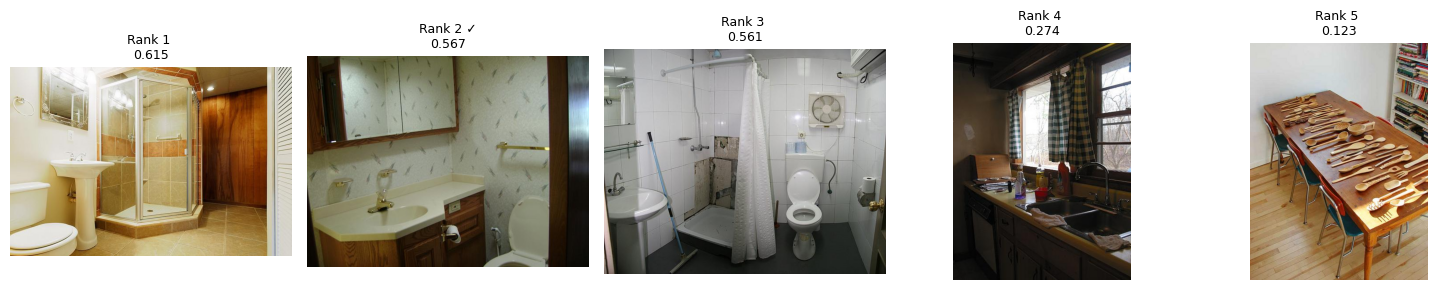

Ground Truth Rank: 3 → 2 ↑ Improved by 1 positions
--------------------------------------------------------------------------------


In [10]:
# Display results
print("\n" + "=" * 80)
print("IMAGE RETRIEVAL RERANKING RESULTS")
print("=" * 80)

for i, (emb_res, rerank_res) in enumerate(zip(image_emb_results, image_rerank_results)):
    print(f"\nQuery {i+1}: {emb_res['caption']}")
    print()

    gt_idx = emb_res['gt_idx']

    # Ground truth
    print("Ground Truth Image:")
    plt.figure(figsize=(3, 3))
    plt.imshow(image_corpus[gt_idx])
    plt.axis('off')
    plt.show()

    # Before reranking
    print("Before Reranking (Embedding Top-5):")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for rank, (ax, idx, score) in enumerate(zip(axes, emb_res['ranked_indices'][:5], emb_res['ranked_scores'][:5]), 1):
        ax.imshow(image_corpus[idx])
        marker = "✓" if idx == gt_idx else ""
        ax.set_title(f"Rank {rank} {marker}\n{score:.3f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # After reranking
    print("After Reranking (Top-5):")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for rank, (ax, idx, score) in enumerate(zip(axes, rerank_res['reranked_indices'][:5], rerank_res['reranked_scores'][:5]), 1):
        ax.imshow(image_corpus[idx])
        marker = "✓" if idx == gt_idx else ""
        ax.set_title(f"Rank {rank} {marker}\n{score:.3f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    comp = display_rank_comparison(emb_res, rerank_res)
    print(f"Ground Truth Rank: {comp['emb_rank']} → {comp['rerank_rank']} {comp['improvement']}")
    print("-" * 80)

In [11]:
# Save for analysis
image_save_data = {
    "results": image_rerank_results,
    "meta": {
        "input_pkl": image_path,
        "top_k": TOP_K
    }
}
out_image = os.path.join(OUTPUT_DIR, "image_rerank_results.pkl")
with open(out_image, "wb") as f:
    pickle.dump(image_save_data, f)
print(f"Saved to {out_image}")

Saved to ./rerank_results/image_rerank_results.pkl


---
# Part 3: Summary

In [12]:
print("=" * 80)
print("RERANKER EXAMPLES SUMMARY")
print("=" * 80)
print()

tasks = [
    ("Text Retrieval", text_emb_results, text_rerank_results),
    ("Image Retrieval", image_emb_results, image_rerank_results)
]

print(f"{'Task':<18} {'Metric':<6} {'Embedding':<10} {'Reranked':<10} {'Change'}")
print("-" * 60)

for task_name, emb_res, rerank_res in tasks:
    metrics = compute_metrics(emb_res, rerank_res)
    for i, m in enumerate(['mrr', 'r@1', 'r@5']):
        emb_val = metrics['emb'][m]
        rerank_val = metrics['rerank'][m]
        change = rerank_val - emb_val
        change_str = f"+{change:.2%}" if change >= 0 else f"{change:.2%}"
        task_display = task_name if i == 0 else ""
        print(f"{task_display:<18} {m.upper():<6} {emb_val:<10.2%} {rerank_val:<10.2%} {change_str}")
    print("-" * 60)

print()
print("Saved rerank outputs:")
print(f"- {OUTPUT_DIR}/text_rerank_results.pkl")
print(f"- {OUTPUT_DIR}/image_rerank_results.pkl")
print("=" * 80)

RERANKER EXAMPLES SUMMARY

Task               Metric Embedding  Reranked   Change
------------------------------------------------------------
Text Retrieval     MRR    26.67%     26.67%     +0.00%
                   R@1    0.00%      0.00%      +0.00%
                   R@5    100.00%    100.00%    +0.00%
------------------------------------------------------------
Image Retrieval    MRR    66.67%     75.00%     +8.33%
                   R@1    50.00%     50.00%     +0.00%
                   R@5    100.00%    100.00%    +0.00%
------------------------------------------------------------

Saved rerank outputs:
- ./rerank_results/text_rerank_results.pkl
- ./rerank_results/image_rerank_results.pkl
